# Д/З по лекции 7: кластеризация
## Выполнила Елизавета Клыкова, МКЛ-221

Датасет [отсюда](https://www.kaggle.com/datasets/zynicide/wine-reviews)

Что делать:
* Подготовьте данные: в датасете 10 колонок, некоторые из них текстовые. Можно использовать колонки, которые на Ваш взгляд наиболее информативны: можно  использовать все, можно убрать некоторые.
    * Если вы используете текстовые колонки, их содержимое следует векторизовать (Doc2Vec, TF-IDF vectorizer, Bert embeddings -- любое на ваш выбор)
    * Для некоторых алгоритмов кластеризации лучше предварительно сделать уменьшение размерности датасета (например,  для K-means)
* Выберите любые 2 алгоритма кластеризации
* Проверьте кластеры с помощью метрик: inertia, silhouette score 
* Расскажите о результатах 
* Визуализации принесут дополнительные 2 балла за дз (да, если вы сделаете все супер-классно, можно получить и больше 10), но добавляются по желанию

## Анализ данных

In [1]:
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MeanShift
from sklearn import metrics
from sklearn.datasets import make_blobs

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.shape

(129971, 13)

In [3]:
data.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


120 тыс. примеров будут кластеризоваться очень долго, поэтому выбросим все строки, где есть нулевые значения.

In [5]:
data.dropna(inplace=True)
data.shape

(22387, 13)

In [6]:
data.nunique()

country                      1
description              20491
designation               9515
points                      21
price                      146
province                     4
region_1                   171
region_2                    17
taster_name                 11
taster_twitter_handle       11
title                    20425
variety                    183
winery                    2791
dtype: int64

## Подготовка данных
Будем сохранять нужные нам данные в отдельный датафрейм.

### Текстовые данные: векторизация Doc2Vec

In [7]:
descs = data['description'].tolist()
descs = [desc.lower().split() for desc in descs]
tagges_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(descs)]

In [8]:
model = Doc2Vec(tagges_docs, vector_size=5, window=2,
                min_count=2, workers=4, seed=RANDOM_SEED)

In [9]:
# создадим список с векторами для каждого текста
vectors = []
for x in tagges_docs:
    vec = list(model.dv[x.tags][0])
    vectors.append(vec)

In [10]:
# датафрейм, где векторы распределены по столбцам
vec_df = pd.DataFrame(vectors, columns=['v1', 'v2', 'v3', 'v4', 'v5'])
vec_df

,v1,v2,v3,v4,v5
0,0.070395,-0.345443,-0.009697,-0.013358,0.374676
1,-0.079373,-0.132506,-0.149825,-0.116562,0.117183
2,0.227323,0.187854,-0.119900,-0.199117,0.320661
3,0.110968,-0.225876,-0.024458,0.113977,0.167287
4,0.194910,-0.215580,-0.139762,-0.349235,0.377757
...,...,...,...,...,...
22382,0.035791,-0.301161,-0.291375,0.005304,0.220058
22383,0.325223,-0.191999,0.435682,-0.046554,0.392630
22384,0.223184,-0.200819,-0.571375,-0.169098,0.501167
22385,-0.067566,-0.343669,-0.214317,-0.575012,0.321713


Сделаем то же самое для колонки title.

In [11]:
titles = data['title'].tolist()
titles = [title.lower().split() for title in titles]
tagged_titles = [TaggedDocument(doc, [i]) for i, doc in enumerate(titles)]

In [12]:
t_model = Doc2Vec(tagged_titles, vector_size=3, window=2,
                  min_count=2, workers=4, seed=RANDOM_SEED)

In [13]:
vec_titles = [list(t_model.dv[x.tags][0]) for x in tagged_titles]
temp_df = pd.DataFrame(vec_titles, columns=['w1', 'w2', 'w3'])
vec_df = vec_df.join(temp_df, how='left')

In [14]:
vec_df

,v1,v2,v3,v4,v5,w1,w2,w3
0,0.070395,-0.345443,-0.009697,-0.013358,0.374676,0.270021,0.500957,0.303837
1,-0.079373,-0.132506,-0.149825,-0.116562,0.117183,-0.117554,-0.226639,-0.090644
2,0.227323,0.187854,-0.119900,-0.199117,0.320661,-0.018859,0.086458,-0.184124
3,0.110968,-0.225876,-0.024458,0.113977,0.167287,-0.321348,-0.096149,0.385743
4,0.194910,-0.215580,-0.139762,-0.349235,0.377757,-0.127544,0.137184,0.335661
...,...,...,...,...,...,...,...,...
22382,0.035791,-0.301161,-0.291375,0.005304,0.220058,0.222962,0.118710,-0.018580
22383,0.325223,-0.191999,0.435682,-0.046554,0.392630,-0.151291,0.159641,-0.158107
22384,0.223184,-0.200819,-0.571375,-0.169098,0.501167,0.159763,0.208795,0.190815
22385,-0.067566,-0.343669,-0.214317,-0.575012,0.321713,0.023334,0.400792,0.092124


### Текстовые данные: категориальные колонки
В некоторых колонках осталось не так уж много уникальных значений. Превратим эти колонки в категориальные.

In [15]:
provinces = data['province'].tolist()
prov_enc = LabelEncoder()
prov_enc.fit(provinces)
print(list(prov_enc.classes_))

['California', 'New York', 'Oregon', 'Washington']


In [16]:
vec_df['province'] = prov_enc.transform(provinces)
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,province
0,0.070395,-0.345443,-0.009697,-0.013358,0.374676,0.270021,0.500957,0.303837,2
1,-0.079373,-0.132506,-0.149825,-0.116562,0.117183,-0.117554,-0.226639,-0.090644,0
2,0.227323,0.187854,-0.119900,-0.199117,0.320661,-0.018859,0.086458,-0.184124,0
3,0.110968,-0.225876,-0.024458,0.113977,0.167287,-0.321348,-0.096149,0.385743,0
4,0.194910,-0.215580,-0.139762,-0.349235,0.377757,-0.127544,0.137184,0.335661,2


In [17]:
regions_1 = data['region_1'].tolist()
regions_2 = data['region_2'].tolist()
reg_enc = LabelEncoder()
reg_enc.fit(regions_1 + regions_2)
vec_df['region_1'] = reg_enc.transform(regions_1)
vec_df['region_2'] = reg_enc.transform(regions_2)

In [18]:
wine_types = data['variety'].tolist()
wine_enc = LabelEncoder()
wine_enc.fit(wine_types)
vec_df['variety'] = wine_enc.transform(wine_types)

In [19]:
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,province,region_1,region_2,variety
0,0.070395,-0.345443,-0.009697,-0.013358,0.374676,0.270021,0.500957,0.303837,2,172,172,111
1,-0.079373,-0.132506,-0.149825,-0.116562,0.117183,-0.117554,-0.226639,-0.090644,0,86,81,19
2,0.227323,0.187854,-0.119900,-0.199117,0.320661,-0.018859,0.086458,-0.184124,0,100,21,74
3,0.110968,-0.225876,-0.024458,0.113977,0.167287,-0.321348,-0.096149,0.385743,0,139,138,111
4,0.194910,-0.215580,-0.139762,-0.349235,0.377757,-0.127544,0.137184,0.335661,2,70,172,111


### Нормирование числовых параметров

In [20]:
data.skew(numeric_only=True)

points    -0.236834
price     16.359345
dtype: float64

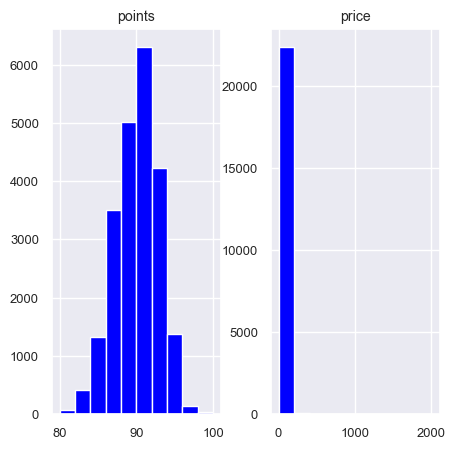

In [21]:
sns.set(font_scale=0.85, rc={'figure.figsize': (5, 5)})
ax = data.hist(color='blue')

In [22]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(data[['points', 'price']])
scaled_df = pd.DataFrame(scaled_features, columns=['points', 'price'])
scaled_df

,points,price
0,-0.903379,0.801076
1,-0.903379,-0.764683
2,-0.903379,-0.662568
3,-0.903379,0.937229
4,-1.259347,0.290503
...,...,...
22382,0.520492,2.162606
22383,0.520492,-0.015842
22384,0.164524,-0.730645
22385,0.164524,-0.220071


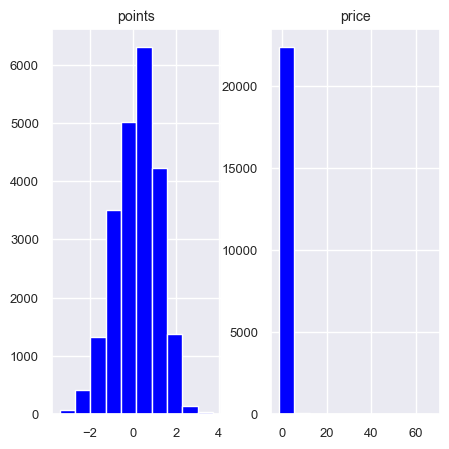

In [23]:
ax = scaled_df.hist(color='blue')

In [24]:
vec_df = vec_df.join(scaled_df, how='left')
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,province,region_1,region_2,variety,points,price
0,0.070395,-0.345443,-0.009697,-0.013358,0.374676,0.270021,0.500957,0.303837,2,172,172,111,-0.903379,0.801076
1,-0.079373,-0.132506,-0.149825,-0.116562,0.117183,-0.117554,-0.226639,-0.090644,0,86,81,19,-0.903379,-0.764683
2,0.227323,0.187854,-0.119900,-0.199117,0.320661,-0.018859,0.086458,-0.184124,0,100,21,74,-0.903379,-0.662568
3,0.110968,-0.225876,-0.024458,0.113977,0.167287,-0.321348,-0.096149,0.385743,0,139,138,111,-0.903379,0.937229
4,0.194910,-0.215580,-0.139762,-0.349235,0.377757,-0.127544,0.137184,0.335661,2,70,172,111,-1.259347,0.290503


### Удаление неинформативных колонок
Кажется, некоторые колонки (такие, как имя автора отзыва и его ник в твиттере) не несут никакой значимой информации о вине как таковом. Если мы хотим кластеризовать сами вина, а не авторов, то эти колонки можно спокойно выбросить. Дальше будем работать с датафреймом vec_df, в котором некоторых из исходных колонок нет:

In [25]:
vec_df.shape

(22387, 14)

In [26]:
vec_df.nunique()

v1          22380
v2          22385
v3          22383
v4          22384
v5          22381
w1          22380
w2          22382
w3          22380
province        4
region_1      171
region_2       17
variety       183
points         21
price         146
dtype: int64

Посмотрим на корреляцию числовых параметров -- цены и рейтинга:

In [27]:
corr_df = vec_df[['points', 'price']]
corr_df.corr()

,points,price
points,1.000000,0.394626
price,0.394626,1.000000


Тут мы видим слабую положительную корреляцию: чем дороже вино, тем лучше его оценивают.

### Уменьшение размерности

In [28]:
pca_2 = PCA(2)
pca_2_result = pca_2.fit_transform(vec_df) 
pca_2_result.shape

(22387, 2)

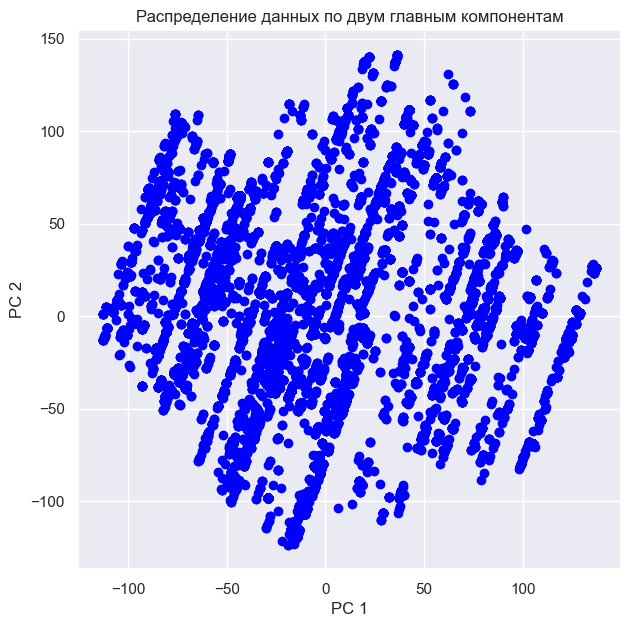

In [29]:
sns.set(rc={'figure.figsize': (7, 7)}, font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Картинка подсказывает, что хорошей кластеризации не получится))

## Кластеризация
В идеальном мире хотелось бы увидеть разделение датасета на кластеры по типам вина или регионам, но, скорее всего, это утопия. Попробуем кластеризовать по числу провинций (4).

In [30]:
kmeans = KMeans(n_clusters=4, n_init=15, random_state=RANDOM_SEED)
kmeans.fit(pca_2_result)

KMeans(n_clusters=4, n_init=15, random_state=42)

Посмотрим на метрики: *инерция* -- сумма квадратов ошибок для каждого кластера. Чем ниже значения инерции, тем более "плотные" получились кластеры, следовательно, тем лучше прошла кластеризация.

In [31]:
kmeans.inertia_

34697211.85043259

Значение инерции очень большое, следовательно, кластеризация плохая.

Попробуем кластеризацию по разным значениям (по числу уникальных значений для разных признаков):

In [32]:
num_clusters = sorted([4, 171, 17, 183, 21, 146])

inertia = {}
silhouette = {}

for i in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=i, n_init=15, random_state=RANDOM_SEED)
    kmeans.fit(pca_2_result)
    inertia[i] = kmeans.inertia_
    silhouette[i] = silhouette_score(pca_2_result,
                                     kmeans.labels_,
                                     metric='euclidean')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.52s/it]


In [33]:
inertia

{4: 34697211.85043259,
 17: 6010177.577157335,
 21: 4576472.702226575,
 146: 270528.59452467196,
 171: 213340.44700605155,
 183: 193764.5967166611}

Чем больше кластеров, тем меньше значение инерции, но оно все равно очень велико.

Теперь посмотрим на силуэты (чем больше значение, тем лучше).

In [34]:
silhouette

{4: 0.4388838349387094,
 17: 0.4965333292760216,
 21: 0.517988939475623,
 146: 0.6902181299022235,
 171: 0.70400594431497,
 183: 0.6988415078069834}

На бОльшем числе кластеров silhouette score выше, но незначительно.

### Визуализация: метрики

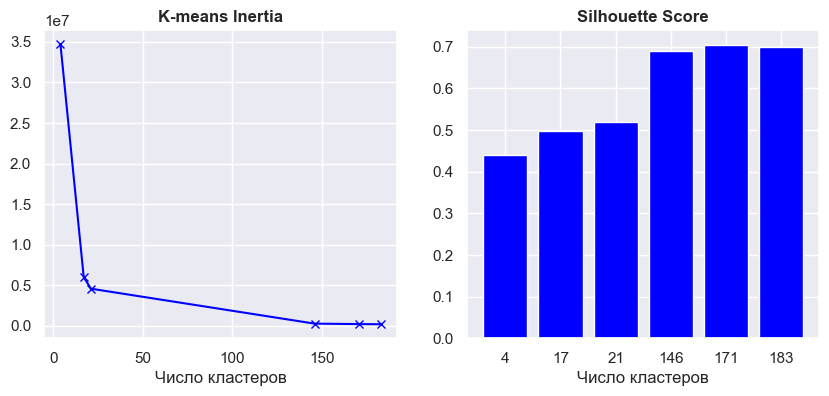

In [35]:
sns.set(font_scale=1, rc={'figure.figsize': (10, 4)})

# значения инерции
plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index
plt.plot(list(inertia.keys()), list(inertia.values()), marker='x', color='blue') 
plt.title('K-means Inertia', fontweight='bold')
plt.xlabel('Число кластеров')
plt.grid(True)

# силуэты
plt.subplot(1, 2, 2)
plt.bar(range(len(silhouette)),
        list(silhouette.values()),
        align='center', color='blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Число кластеров')
plt.grid(True)

plt.show()

Наше лучшее число кластеров -- 171.

In [36]:
kmeans = KMeans(n_clusters=171, n_init=15, random_state=RANDOM_SEED)
kmeans_labels = kmeans.fit_predict(pca_2_result)
centroids = kmeans.cluster_centers_
display(pd.Series(kmeans_labels).value_counts())

13     1044
21      739
14      702
6       580
27      556
       ... 
49       17
164      14
52       12
122      11
158      11
Length: 171, dtype: int64

In [37]:
pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['kmeans'] = kmeans_labels

In [38]:
pca_2_df

,0,1,kmeans
0,122.082913,-18.092978,13
1,-17.562738,-40.483449,143
2,-48.354010,-31.049418,48
3,76.968482,-3.629396,27
4,70.087894,54.794238,99
...,...,...,...
22382,6.191554,-49.371121,152
22383,11.645324,-33.212884,60
22384,-40.334467,-78.468291,65
22385,-14.723972,-32.088220,114


### Визуализация: кластеры

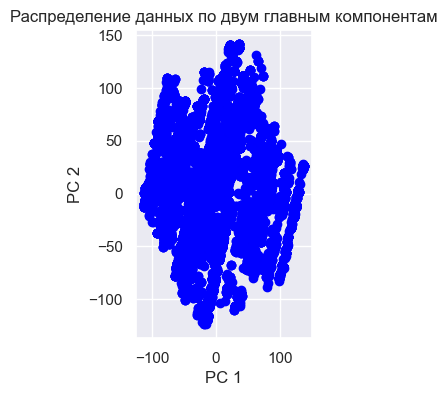

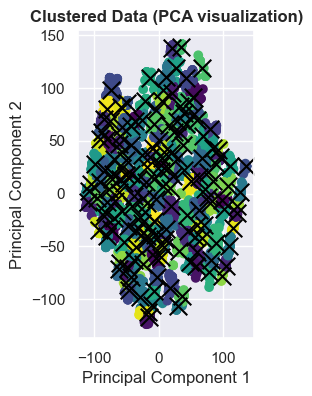

In [39]:
sns.set(rc={'figure.figsize': (5, 4)}, font_scale=1)

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index
plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

plt.subplot(1, 2, 2)
sns.set(rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Осталось посчитать метрики, хотя и без них понятно, что все как-то не очень:

In [40]:
# силуэты: определяется на промежутке [-1;1] (чем выше тем лучше)
# инерция: определяется на [0, inf) (чем ниже тем лучше)

print('Inertia score: %0.1f' % kmeans.inertia_)
print('Silhouette score: %0.1f' % silhouette_score(pca_2_result,
                                                   kmeans.labels_,
                                                   metric='euclidean'))

Inertia score: 213340.4
Silhouette score: 0.7


Кластеры получились плохие :(

### Mean Shift
Интересно попробовать, потому что этот алгоритм не распихивает все объекты по кластерам, даже если они туда не лезут.

In [41]:
# bandwidth - как раз размер этого кружка, но его сложно подбирать самому, т.к. в каждой задаче он будет свой
# вот так можно узнать, что будет по умолчанию и начать с этого значения, постепенно уменьшая или увеличивая

sklearn.cluster.estimate_bandwidth(vec_df)

103.19225075354201

In [43]:
cluster = MeanShift(cluster_all=False, bandwidth=103)
cluster.fit(vec_df)

MeanShift(bandwidth=103, cluster_all=False)

In [44]:
len(set(cluster.labels_))

2

In [45]:
vec_df['mean_shift'] = cluster.labels_
vec_df['mean_shift'].value_counts() 

 0    13898
-1     8489
Name: mean_shift, dtype: int64

Ну это, конечно, просто восторг: данные распределились на кластер мусора и не-мусора))

In [47]:
# print('Inertia score: %0.1f' % cluster.inertia_)
print('Silhouette score: %0.1f' % silhouette_score(vec_df.drop(columns=['mean_shift']),
                                                   cluster.labels_,
                                                   metric='euclidean'))

Silhouette score: 0.3


In [49]:
vec_df.drop(columns=['mean_shift'], inplace=True)

### DBSCAN

In [50]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

cluster = DBSCAN(min_samples=5, eps=0.5)
cluster.fit(vec_df)

DBSCAN()

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [51]:
vec_df['dbscan'] = cluster.labels_
vec_df['dbscan'].value_counts() 

-1      19486
 1        578
 4        352
 10       181
 14       168
        ...  
 108        4
 77         4
 115        4
 68         4
 52         4
Name: dbscan, Length: 138, dtype: int64

In [55]:
print('Silhouette score: %0.3f' % silhouette_score(vec_df.drop(columns=['dbscan']),
                                                   cluster.labels_,
                                                   metric='euclidean'))

Silhouette score: -0.735


In [56]:
vec_df.drop(columns=['dbscan'], inplace=True)

## Результаты

Кластеризация всеми методами получилась плохая. Скорее всего, это просто особенность датасета и задачи: какая-нибудь регрессия или классификация вполне могла бы получиться (например, предсказание оценки или цены по описанию), но кластеризоваться данные не хотят из-за своей разнородности. Если бы у нас были какие-нибудь данные о составе вин, как в датасете на паре, то вина могли бы кластеризоваться по типам.

Чем большее число кластеров мы задавали, тем лучше кластеризовались данные (по крайней мере, для K-Means это было очевидно). Возможно, данные можно было бы разбить на много-много мелких кластеров, но визуализировать и анализировать их глазами было бы нереально. Кроме того, непонятно, как можно было бы интерпретировать такое число кластеров: может быть, как вина, произведенные на одной винодельне? Для таких выводов нужно обладать некоторым уровнем знаний по данной теме, которого лично у меня нет.